## Objects resulting from resolving plate boundaries

We're often going to need to resolve plate boundaries at past times, then analyse aspects of the geometry and kinematices. 

There are some major gotchas, as the objects that result from a call to resolve (like shared_boundary_sections, can easily spawn geometries that are not in the resolved (reconstructed) geometry, but in the present day geometry. 

This notebook explores some of these issues, looking at teh Pacific/Cocos plate.

More detailed notes in `../notes.pygplates_objects.md`



In [1]:
import sys                                                                      
sys.path.append('/usr/lib/pygplates/revision18/')

import pygplates  
import numpy as np
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import cartopy as cart
import glob
from matplotlib import cm
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
#from netCDF4 import Dataset as netcdf_dataset
import sys
import math


# create a dateline wrapper object
wrapper = pygplates.DateLineWrapper(0.)

In [2]:
###########
#Import Muller 2016 data
###########
pre = '/home/dansandiford/data/geophysical_data/Gplates_stuff/Muller_etal_AREPS_Supplement/'
input_topology_filename  = pre + 'Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml'
input_features_filename  = pre + 'Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml'

rotation_filename = pre + 'Global_EarthByte_230-0Ma_GK07_AREPS.rot'
topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)

In [5]:
######Resolve plates and boundaries!######

time = 5
anchor_plate_id = 901 #Pacific
other_plate = 909 #Cocos


resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(topology_features, rotation_model, 
                             resolved_topologies, time, 
                             shared_boundary_sections, anchor_plate_id)


In [31]:
#pull these lists apart to see what's inside

ix = 2
rtb = resolved_topologies[ix]
rts = shared_boundary_sections[ix]
rtsss = sbt.get_shared_sub_segments()[0]

print(type(rtb))
print(type(rts))
print(type(rtsss))

#Whan analysing a plate boundary configuration, you should try to extract the ResolvedTopologicalSharedSubSegment
#These are defined as:

#the shared subset of vertices of a reconstructed topological section that uniquely contribute...
#to the boundaries of one or more resolved topologies.


<class 'pygplates.ResolvedTopologicalBoundary'>
<class 'pygplates.ResolvedTopologicalSection'>
<class 'pygplates.ResolvedTopologicalSharedSubSegment'>


In [58]:
#The first gotcha. 
#Depending on how you access the geometries, you could  end up with a reconstructed...
#or unreconstructed object

#For an object of type pygplates.ResolvedTopologicalSharedSubSegment, 
#you could access the underlying coordinates through at least three ways: 

print(rtsss.get_resolved_feature().get_geometry().get_centroid().to_lat_lon_array())
print(rtsss.get_geometry().get_centroid().to_lat_lon_array()[0])
print(rtsss.get_geometry().get_points().get_centroid().to_lat_lon_array()[0])
print(rtsss.get_feature().get_geometry().get_centroid().to_lat_lon_array())

#The first three methods get the reconstructed position,  
# I assume that  using the `get_feature` method gives the feature in it present day coordinates

print('.............')

#Another gotcha, you could also mistakenly access the ResolvedTopologicalSection
#These contain, effectively, plate boundaries with some degree of overlap

print(rtsss.get_topological_section_geometry().get_centroid().to_lat_lon_array())
print(rtsss.get_topological_section().get_reconstructed_geometry().get_centroid().to_lat_lon_array())

[[16.9832425  57.83402974]]
[16.9832425  57.83402974]
[16.9832425  57.83402974]
[[19.93773883 62.95275476]]
.............
[[17.19526862 58.01284588]]
[[17.19526862 58.01284588]]


In [34]:
#Interestingly, the `sbt` object (ResolvedTopologicalSection) does not have the 
#`get_resolved_feature` method. Which seems confusing to me. Instead a bunch of different 'getters' are available
#again the gotcha is basically to avoid the get_feature().get_geometry()

print(rts.get_topological_section_geometry().get_centroid().to_lat_lon_array())
print(rts.get_topological_section().get_reconstructed_geometry().get_centroid().to_lat_lon_array())
print(rts.get_feature().get_geometry().get_centroid().to_lat_lon_array())

[[17.19526862 58.01284588]]
[[17.19526862 58.01284588]]
[[19.93773883 62.95275476]]


__The lesson__: 

avoid .get_feature() when dealing with ResolvedTopologicalSections or 
ResolvedTopologicalSharedSubSegment

## Example from Pacific-Cocos boundary

In [48]:


# Iterate over the shared boundary sections of all resolved topologies.

coc_rts = []     #ResolvedTopologicalSection s
coc_rtsss = []   #ResolvedTopologicalSharedSubSegment


for shared_boundary_section in shared_boundary_sections:
    

    # These are the parts of the ridge line that actually contribute to topological boundaries.
    for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
    
        spreading_feature = shared_sub_segment.get_feature()
    
        if 'COCO-PAC MOR' in spreading_feature.get_name():
        #if 'Antarctica ANT_025_021' in spreading_feature.get_name():
            
            coc_rts.append(shared_boundary_section)
            coc_rtsss.append(shared_sub_segment)
            

In [52]:
print(coc_rts[0])
print(coc_rtsss[0])

In [39]:
######Also reconstruct coastlines, for plotting ######


#reconstructed_geometries can be either an export filename or a Python list.
#for plotting with Cartopy, the easiest way seems to be to dump to a shapfile then use:
#fname = 'tmp/tmp.shp'
#shape_feature = ShapelyFeature(Reader(fname).geometries(),
#                                ccrs.PlateCarree(), edgecolor='black',facecolor='green', alpha = 0.1)
#ax.add_feature(shape_feature)
#*********************



output_reconstructed_feature_filename = 'tmp/tmp.shp'
output_reconstructed_features = []

# Use pygplates to carry out the reconstruction 


pygplates.reconstruct(input_features_filename, 
                      rotation_model,
                      #output_reconstructed_features,
                      output_reconstructed_feature_filename, 
                      time, anchor_plate_id)


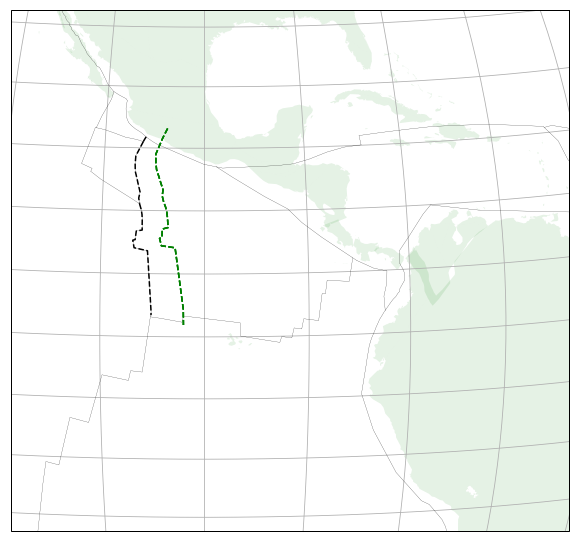

In [60]:
plt.figure(figsize=(10,10))


projection =ccrs.Orthographic(-100, 8)

ax = plt.axes(projection=projection)

ax.set_extent((-60.,
 -120,
 30,
 -20.), crs=ccrs.PlateCarree())

#####Plot reconstructed coastlines
fname = 'tmp/tmp.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), edgecolor='none',facecolor='green', alpha = 0.1)
ax.add_feature(shape_feature)
#######

#### Plot all resolved plate boundaries (ResolvedTopologicalSection)
for shared_boundary_section in shared_boundary_sections:
    
    # The shared sub-segments contribute either to the ridges or to the subduction zones.  
    for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
        
        #Note the use of .get_geometry() NOT .get_feature().get_geometry()
        split_geometry = wrapper.wrap(shared_sub_segment.get_geometry())
        for geometry in split_geometry:
            X=[]
            Y=[]
            for point in geometry.get_points():
                X.append(point.get_longitude()),Y.append(point.get_latitude())
            #x,y = pmap(X,Y)
    
            ax.plot(X,Y,c = 'k', transform = ccrs.PlateCarree(), lw=0.2) 
####        
        
        


#### Now plot the Section of Cocos Ridge



###The right way...a non-overlapping plate boundary in the reconstructed position
for ridge_feat in coc_rtsss:
    ax.plot(ridge_feat.get_geometry().to_lat_lon_array()[:,1], 
            ridge_feat.get_geometry().to_lat_lon_array()[:,0],
            transform = ccrs.PlateCarree(), c ='k', ls = '--')

###The wrong way...an overallping plate boundary in the present-day position
for ridge_feat in coc_rtsss:
    ax.plot(ridge_feat.get_feature().get_geometry().to_lat_lon_array()[:,1], 
            ridge_feat.get_feature().get_geometry().to_lat_lon_array()[:,0],
            transform = ccrs.PlateCarree(), c ='g', ls = '--')
    


ax.gridlines()
#ax.coastlines()

plt.show()